In [11]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
data = pd.read_csv('data.csv')
data


,steps_during_morning,steps_during_afternoon,steps_during_evening,steps_during_bedtime,steps_during_morning_ndays_mean,steps_during_morning_ndays_stdev,steps_during_morning_ndays_gradient,steps_during_afternoon_ndays_mean,steps_during_afternoon_ndays_stdev,steps_during_afternoon_ndays_gradient,...,mesor_ndays_stdev,goodness_of_fit_ndays_mean,goodness_of_fit_ndays_stdev,goodness_of_fit_ndays_gradient,amplitude,mesor,acrophase,goodness_of_fit,timestamp,patient_id
0,46.0,4271.0,3886.0,238.0,2407.000,1517.620,1359.000,6049.67,4045.350,4024.0000,...,1.809390,0.468774,0.092405,0.028774,16.55450,75.8027,13.51340,0.636873,2015-08-30,0
1,8975.0,4294.0,1209.0,238.0,7144.570,2499.000,650.500,7533.57,3439.870,-463.6070,...,2.250650,0.615644,0.048942,-0.012300,13.46240,78.3996,13.83120,0.473510,2015-10-28,0
2,204.0,428.0,835.0,617.0,3088.710,1675.700,524.071,4489.14,2921.570,-81.9286,...,3.913680,0.448787,0.137939,0.052349,11.49640,67.4808,15.19090,0.210210,2015-05-24,0
3,9344.0,2775.0,1269.0,40.0,2935.000,3617.560,5116.000,10290.00,420.021,594.0000,...,2.929610,0.265212,0.179512,-0.004652,10.52350,80.3467,9.45339,0.146700,2018-05-22,0
4,1234.0,3591.0,1269.0,1408.0,590.333,398.801,-95.200,8565.80,3464.000,1714.0000,...,11.264700,0.212145,0.167711,-0.012779,18.17880,85.3592,18.04340,0.263283,2018-06-23,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58831,5757.0,5435.0,1269.0,238.0,5063.250,581.089,22.700,8116.50,3000.110,1252.4000,...,2.516985,0.421176,0.130205,0.000042,11.43380,77.8584,16.57375,0.424519,2019-05-09,224
58832,47.0,11497.0,1269.0,1804.0,1063.400,2134.520,23.400,7524.80,3980.090,-1334.8000,...,2.232910,0.338700,0.227881,0.183168,14.74460,85.0776,17.53210,0.401185,2019-04-22,224
58833,5302.0,11782.0,1269.0,238.0,4862.500,921.360,-390.900,6993.00,1623.910,-1107.4000,...,2.516985,0.421176,0.130205,0.000042,11.43380,77.8584,16.57375,0.424519,2019-05-07,224
58834,5807.0,6950.0,1269.0,238.0,5124.000,652.264,456.200,7698.00,3290.230,-55.8000,...,2.516985,0.421176,0.130205,0.000042,11.43380,77.8584,16.57375,0.424519,2019-05-10,224


In [3]:
# timestamp를 datetime 타입으로 변환 (안 돼 있다면)
data['timestamp'] = pd.to_datetime(data['timestamp'])

# 정렬
data = data.sort_values(by=['patient_id', 'timestamp']).reset_index(drop=True)
print(data)

       steps_during_morning  steps_during_afternoon  steps_during_evening  \
0                    1234.0                  6754.0                 499.0   
1                    4800.0                  6657.0                1828.0   
2                    4308.0                  8619.0                 210.0   
3                    5588.0                  6085.0                 936.0   
4                    7171.0                 13155.0                3768.0   
...                     ...                     ...                   ...   
58831                5226.0                  8911.0                1269.0   
58832                5757.0                  5435.0                1269.0   
58833                5807.0                  6950.0                1269.0   
58834                5870.0                 12514.0                1410.0   
58835                4711.0                  1921.0                1269.0   

       steps_during_bedtime  steps_during_morning_ndays_mean  \
0          

In [4]:
from sklearn.preprocessing import StandardScaler

# 수치형 컬럼만 선택
numeric_columns = data.select_dtypes(include=[np.number]).columns
numeric_columns = [col for col in numeric_columns if col != 'patient_id']

# StandardScaler를 사용하여 정규화
scaler = StandardScaler()
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])

# 정규화된 데이터 저장
data.to_csv('normalized_data.csv', index=False)

print("정규화가 완료되었습니다.")
print("\n처음 5개 행:")
print(data.head())

정규화가 완료되었습니다.

처음 5개 행:
   steps_during_morning  steps_during_afternoon  steps_during_evening  \
0             -0.285944                0.857065             -0.688989   
1              1.359486                0.826138             -0.022832   
2              1.132467                1.451692             -0.833850   
3              1.723087                0.643765             -0.469944   
4              2.453517                2.897925              0.949587   

   steps_during_bedtime  steps_during_morning_ndays_mean  \
0             -0.312031                        -0.209601   
1              1.052702                        -0.209601   
2              2.525143                        -0.209601   
3             -0.312031                         1.631711   
4             -0.530074                         1.839898   

   steps_during_morning_ndays_stdev  steps_during_morning_ndays_gradient  \
0                         -0.150473                            -0.001276   
1                       

In [5]:
def compute_sleep_quality_score(row):
    efficiency = row["sleep_efficiency"]
    length = row["sleep_length"]
    counts = row["sleep_counts"]
    onset_dev = row["sleep_onset_dev"]

    score = (0.35 * efficiency + 0.2 * length - 0.2 * counts - 0.25 * onset_dev)
    return round(score * 100, 2)
data['sleep_quality_score'] = data.apply(compute_sleep_quality_score, axis=1)

# 로그를 씌우기 위해 음수 방지: 모든 값에 offset을 더함
#data['sleep_quality_score'] = np.log(data['sleep_quality_score'])

print(data['sleep_quality_score'].describe())

count    58836.000000
mean         0.000465
std         52.460473
min       -592.130000
25%        -14.490000
50%         16.965000
75%         25.340000
max        184.350000
Name: sleep_quality_score, dtype: float64


In [6]:
# 예: 상위 20%, 하위 20% 그룹 만들어서 비교
threshold_high = data['sleep_quality_score'].quantile(0.75)
threshold_low = data['sleep_quality_score'].quantile(0.25)
print(threshold_high,threshold_low)

data['score_level'] = 'mid'
data.loc[data['sleep_quality_score'] >= threshold_high, 'score_level'] = 'good'
data.loc[data['sleep_quality_score'] <= threshold_low, 'score_level'] = 'bad'

25.34 -14.49


In [7]:
data = data.drop([
    'sleep_length_ndays_mean',
    'sleep_efficiency_ndays_mean',
    'sleep_onset_dev_ndays_mean',
    'sleep_counts_ndays_mean',
    'sleep_length',
    'sleep_efficiency',
    'sleep_onset_dev',
    'sleep_counts'
], axis=1)





In [8]:
# 정규화된 데이터 저장
data.to_csv('processed_data.csv', index=False)


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# 예시: 수면의 질을 예측할 특징(features)와 목표(target)
features = data.drop(columns=['sleep_quality_score', 'score_level', 'patient_id', 'timestamp'])
target = data['score_level']  # 또는 score_level로 분류 모델 만들 수도 있음

# 라벨 인코딩
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(target)  # 0, 1, 2
y_categorical = to_categorical(y_encoded)

# 80% 훈련, 20% 테스트
X_train, X_test, y_train, y_test = train_test_split(
    features,
    y_categorical,
    test_size=0.2, 
    random_state=42  # 결과 재현 가능하게
)

"""# 훈련, 테스트 데이터 저장
X_train.to_csv('X_train.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
y_test.to_csv('y_test.csv', index=False)
"""

"# 훈련, 테스트 데이터 저장\nX_train.to_csv('X_train.csv', index=False)\nX_test.to_csv('X_test.csv', index=False)\ny_train.to_csv('y_train.csv', index=False)\ny_test.to_csv('y_test.csv', index=False)\n"

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report



# 모델 정의
model = Sequential([Dense(256, input_dim=X_train.shape[1], activation='relu'), Dense(64, activation='relu'),Dense(64, activation='relu'),Dense(3, activation='softmax')])

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

# 학습
history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32)

# 평가
loss, acc = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {acc:.3f}')

# 예측 (확률)
y_pred_proba = model.predict(X_test)

# 예측 클래스
y_pred = np.argmax(y_pred_proba, axis=1)

# 실제 클래스
y_true = np.argmax(y_test, axis=1)

# 오차행렬
cm = confusion_matrix(y_true, y_pred)
labels = label_encoder.classes_



C:\Users\82102\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.5621 - loss: 0.9232 - val_accuracy: 0.6034 - val_loss: 0.8386
Epoch 2/50
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6225 - loss: 0.7932 - val_accuracy: 0.6157 - val_loss: 0.8044
Epoch 3/50
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.6380 - loss: 0.7522 - val_accuracy: 0.6197 - val_loss: 0.7958
Epoch 4/50
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.6574 - loss: 0.7236 - val_accuracy: 0.6264 - val_loss: 0.7887
Epoch 5/50
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6614 - loss: 0.7038 - val_accuracy: 0.6161 - val_loss: 0.8030
Epoch 6/50
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6774 - loss: 0.6813 - val_accuracy: 0.6205 - val_loss: 0.7975
Epoch 7/50
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.6896 - loss: 0.6631 - val_accuracy: 0.6189 - val_loss: 0.7967
Epoch 8/50
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.7009 - loss: 0.6465

NameError: name 'plt' is not defined

In [ ]:

# 시각화
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 분류 성능 보고서
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=labels))

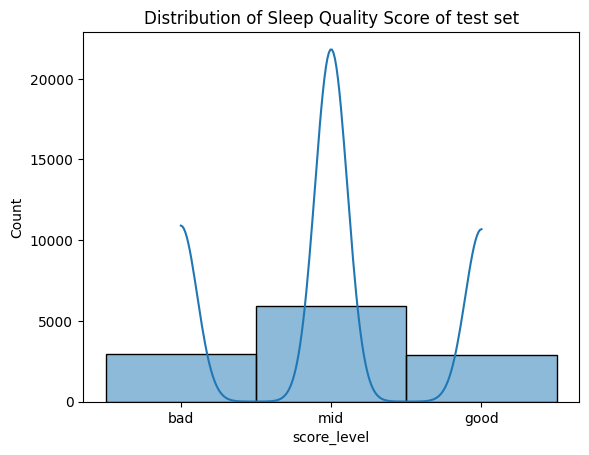

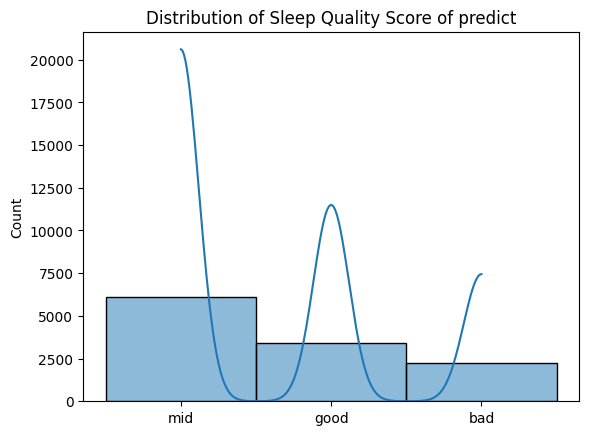

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# 히스토그램으로 분포 보기
sns.histplot(y_test, kde=True)
plt.title('Distribution of Sleep Quality Score of test set')
plt.show()

# 히스토그램으로 분포 보기
sns.histplot(y_pred, kde=True)
plt.title('Distribution of Sleep Quality Score of predict')
plt.show()
